# Code to load, calculate and plot histograms of SCALE-RM Data
---

Choose the date, time and ensemble size. Previously used dates are 29.05.2016 12:00UTC and 01.06.2016 12:00UTC.

#### !!! Careful with ensemble size of 1000 members, a lot of free memory is necessary !!!

Calculated variables:
1. stab: Stability, calculated between the level above and below with log in denominator
2. prec: Precipitation, unit is mm/s !!!
3. prec_max: Maximum Precipitation of the whole ensemble at every point in domain
4. prec_prob: Precipitaion probability, definition of precipitation is 0.1mm/h
5. m_cloud: Mask, where a cloudy datapoint is defined as 1 and non cloudy as 0
6. h_cloud: Same as m_cloud, but instead of 1 it contains the pressure level of the cloud and instead of 0 it contains np.nan
7. p_cloud: Probability of at least one cloud in a data column over the whole ensemble
8. ex_cloud: Number of cloudy levels in a data column. Interpreted as the vertical extent of one cloud, since the results of an exact calculation are the same but much slower.
9. ctl: Level of the cloud top (0-20)
10. ctp: Cloud Top Pressure level (975hPa-100hPa)
11. w: Vertical wind data (means over ensemble, levels and both are used)


In [1]:
%matplotlib inline 

import matplotlib
from matplotlib import pyplot as plt

import sys, os, copy, scipy, math, getpass, subprocess, argparse, time, re, pdb, socket, warnings
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
from enstools.io import read, write

import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import dask

In [2]:
import warnings

## Load Data

In [3]:
# Load temperature data 'TH0020', 'TH0040', 'TH0200', 'TH1000'
# Load precipitation data 'EN0020', 'EN0040', 'EN0200', 'EN1000'
# Load cloud and w data 'CL0020', 'CL0040', 'CL0200', 'CL1000'
# 29.05.2016 12:00 and 01.06.2016 12:00 available (used forecast is 15:00 UTC)
# Change ens for different ensemble sizes. 20, 40, 200, 1000 Members available

dask.config.set(scheduler='processes')

day = '29'
month = '05'
time = '1200'
ens = '20'

date = month+day

#convert for the plots
if month == '05':
    m = 'Mai'
elif month == '06':
    m = 'Juni'
if time == '1200':
    t = '15:00'


if ens == '20':
    num = '0020'
    ensemble_CL = 'CL0020'
    ensemble_TH = 'TH0020'
    ensemble_PR = 'EN0020'
elif ens == '40':
    num = '0040'
    ensemble_CL = 'CL0040'
    ensemble_TH = 'TH0040'
    ensemble_PR = 'EN0040'
elif ens == '200':
    num = '0200'
    ensemble_CL = 'CL0200'
    ensemble_TH = 'TH0200'
    ensemble_PR = 'EN0200'
elif ens == '1000':
    num = '1000'
    ensemble_CL = 'CL1000'
    ensemble_TH = 'TH1000'
    ensemble_PR = 'EN1000'

path_CL = '/scratch/das/tnecker/kwork/run/'+ensemble_CL+'/2016'+month+day+time+'/'+num+'/member*.nc'
dataset_CL = read(path_CL, member_by_filename="member(.*?).nc", in_memory=False)

path_TH = '/scratch/das/tnecker/kwork/run/'+ensemble_TH+'/2016'+month+day+time+'/'+num+'/member*.nc'
dataset_TH = read(path_TH, member_by_filename="member(.*?).nc", in_memory=False)

path_PR = '/scratch/das/tnecker/kwork/run/'+ensemble_PR+'/2016'+month+day+time+'/'+num+'/member*.nc'
dataset_PR= read(path_PR, member_by_filename="member(.*?).nc", in_memory=False)

warnings.filterwarnings("default")
warnings.filterwarnings("ignore")

/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/

In [4]:
# Check datasets
dataset_CL, dataset_TH, dataset_PR

(<xarray.Dataset>
 Dimensions:  (time: 2, ens: 20, lev: 20, lat: 352, lon: 250)
 Coordinates:
   * lat      (lat) float64 1.0 2.0 3.0 4.0 5.0 ... 348.0 349.0 350.0 351.0 352.0
   * lev      (lev) float64 975.0 950.0 925.0 900.0 ... 250.0 200.0 150.0 100.0
   * lon      (lon) float64 1.0 2.0 3.0 4.0 5.0 ... 246.0 247.0 248.0 249.0 250.0
   * time     (time) datetime64[ns] 2016-05-29T14:00:00 2016-05-29T15:00:00
   * ens      (ens) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
 Data variables:
     dbz      (time, ens, lev, lat, lon) float32 dask.array<chunksize=(2, 1, 20, 352, 250), meta=np.ndarray>
     qhydro   (time, ens, lev, lat, lon) float32 dask.array<chunksize=(2, 1, 20, 352, 250), meta=np.ndarray>
     w        (time, ens, lev, lat, lon) float32 dask.array<chunksize=(2, 1, 20, 352, 250), meta=np.ndarray>
 Attributes:
     CDI:          Climate Data Interface version 1.9.4 (http://mpimet.mpg.de/...
     CDO:          Climate Data Operators version 1.9.4 (http://mpimet

In [5]:
# Load domain coordinates (Cutoff at the edges due to unrealistic results)
lat2d=np.load('/scratch/das/tnecker/kwork/experiments/lat2d_high_resolution.npy')[7:345,12:243]
lon2d=np.load('/scratch/das/tnecker/kwork/experiments/lon2d_high_resolution.npy')[7:345,12:243]

## Calculations

### Stability

In [6]:
# Convert to np.array
theta_array = np.array(dataset_TH['theta'].isel(time=3,lat = np.arange(7,345,1),lon = np.arange(12,243,1)))

In [7]:
# Calculation of stability (Minus in the equation is convention for positive stability)
stab = np.zeros([len(dataset_TH.coords['ens'].values),len(dataset_TH.coords['lev'].values)-2,len(lat2d[::,0]),len(lon2d[0,::])])

for i in range(1,19,1):
    stab[::,i-1,::,::] = -(theta_array[::,i+1] - theta_array[::,i-1])/(np.log(dataset_TH.coords['lev'].values[i+1]) - np.log(dataset_TH.coords['lev'].values[i-1]))

### Precipitation

In [8]:
# Convert to np.array
prec = np.array(dataset_PR['prec'].isel(time=3,lat = np.arange(7,345,1),lon = np.arange(12,243,1)))

In [9]:
# Calculation of maximum precipitation and probability
prec_max = np.max(prec,axis=0,keepdims=False)

prec_def = np.where(prec>=0.1/3600,1,0)
prec_prob = np.mean(prec_def,axis=0)

### Clouds

In [16]:
def cloud_def(array_ens):
    """
    Description
        Computes cloud mask in each layer and cloumn
        Cloud: Hy > 10^-6 kg/kg
    ----------
    Parameters
        numpy.array : array_ens (ens, lev, lat, lon) Ensemble of Total Hydrometeors in kg/kg
    ----------
    Returns
        numpy.array : m_cloud (ens, lev, lat, lon) defines cloudy pixel as 1 and non cloudy pixel as 0
    """
    
    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")
        m_cloud = np.where(array_ens > 1e-6,1,0)
        return m_cloud

In [22]:
def cloud_level(m_cloud):
    """
    Description
        Computes level of every cloud
        Cloud: Hy > 10^-6 kg/kg
    ----------
    Parameters
        numpy.array : m_cloud (ens, lev, lat, lon) Ensemble of Total Hydrometeors in kg/kg
    ----------
    Returns
        numpy.array : h_cloud (ens, lev, lat, lon) Pressure Level of every cloud
    """
    
    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")
        h_cloud = np.empty(np.shape(m_cloud))
        for i in range(len(m_cloud[1])):
            h_cloud[::,i,::,::] = np.where(m_cloud[::,i,::,::]==1,dataset_CL.coords['lev'].values[i],np.nan)
        return h_cloud

In [23]:
def cloud_analysis_per_column(array_ens, probability):
    """
    Description
        Computes probability of cloud and number of cloud layers in each cloumn
        Cloud: Hy > 10^-6 kg/kg
    ----------
    Parameters
        numpy.array : array_ens (ens, lev, lat, lon) Ensemble of Total Hydrometeors in kg/kg
    ----------
    Returns
        numpy.array : p_cloud (lat, lon) Probability of cloud between 0 and 1
        numpy.array : ex_cloud (ens, lat, lon) Number of cloudy layers per column (cloud extent)
    """
    
    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")
        # Mask nan entries / missing data
        array_ens_masked = np.ma.masked_array(array_ens, mask=np.isnan(array_ens))

        # Mask non cloudy levels based on threshold 1e-6
        cloudy_data_false = np.ma.masked_less_equal(array_ens_masked, 1e-6)
        cloudy_data_false_mask = np.ma.getmask(cloudy_data_false)

        if probability:
            # Probability of cloud
            number_of_clouds_in_column_per_member = np.sum(~cloudy_data_false_mask,axis=(1))
            p_cloud = np.sum(np.ma.getmask(np.ma.masked_greater(number_of_clouds_in_column_per_member, 0)),axis=0) / float(array_ens.shape[0])
            return p_cloud
        else:
            # Cloudy layers per column (cloud extent)
            ex_cloud = np.sum(~cloudy_data_false_mask, axis=(1))
            return ex_cloud

In [24]:
def get_cloud_top_level(array_ens):
    """
    Description
        Find Cloud Top Level (CTL) / array_ens (ens, lev, lat, lon)
    ----------
    Parameters
        numpy.array : array_ens (ens, lev, lat, lon) Ensemble of Total Hydrometeors in kg/kg
    ----------
    Returns
        numpy.array : cloud_index / ctl mean, max, min, std (lat, lon) (0,20)
    """

    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")

        # Mask nan entries / missing data
        array_ens_masked = np.ma.masked_array(array_ens, mask=np.isnan(array_ens))

        # Mask non cloudy levels based on hy threshold 1e-6 kg/kg
        # Threshold as in Kerr et al 2015 / Zhang et al 2021 = 10⁻6 kg/kg
        cloudy_data_false = np.ma.masked_less_equal(array_ens_masked, 1e-6)
        cloudy_data_false_mask = np.ma.getmask(cloudy_data_false)
        cloudy_data_true_mask = ~cloudy_data_false_mask
        # cloudmask (cloud=true/1)

        # Create index array with increasing indices from 0=sfc to 1=TOA with same dimensions as ensemble array
        array_ens_ones = np.ones_like(cloudy_data_true_mask, dtype=np.int)
        array_ens_cloud = np.copy(cloudy_data_true_mask).astype(int)
        array_ens_index = np.cumsum(array_ens_ones, axis=1) - 1
        array_ens_argmax_ = array_ens_cloud * array_ens_index

        # Fill index array with np.nan where cloudfree
        array_ens_argmax = np.where(cloudy_data_false_mask, np.nan, array_ens_argmax_)

        # Compute ensemble max of CTL
        # find max index of ctl in column along ensemble dimension
        array_argmax = np.nanmax(array_ens_argmax, axis=1)
        ctl_max_ = np.nanmax(array_argmax, axis=0)

        # Compute ensemble min of CTL
        ctl_argmin = np.where(array_argmax == 0 , 20, array_argmax)
        ctl_min_ = np.nanmin(ctl_argmin, axis=0)

        # Compute ensemble mean of CTL
        ctl_argmean = np.where(array_argmax == 0 , np.nan, array_argmax)
        ctl_mean_ = np.nanmean(ctl_argmean, axis=0)

        # Compute ensemble std of CTL
        ctl_std_ = np.nanstd(ctl_argmean, axis=0)

        # Mask column where all member are cloudfree with np.nan
        ctl_mean = np.where(ctl_mean_ == np.nan, np.nan,  np.round(ctl_mean_,0))
        ctl_max = np.where(ctl_min_ == 20, np.nan,  ctl_max_)
        ctl_min = np.where(ctl_min_ == 20, np.nan,  ctl_min_)
        ctl_std = np.where(ctl_min_ == 20, np.nan,  ctl_std_)

        return ctl_mean, ctl_max, ctl_min, ctl_std

In [25]:
def ctl_to_ctp(ctl):
    """
    Description
        Converts Cloud Top Level to Cloud Top Pressure (CTP) / array_ens (ens, lev, lat, lon)
    ----------
    Parameters
        numpy.array : cloud_index / ctl (lat, lon) (0,19)
    ----------
    Returns
        numpy.array : Cloud Top Pressure (ctp) (lat, lon) (975, ..., 100 hPa)
    """
    
    with warnings.catch_warnings(): # avoid warnings due to np.nan
        warnings.simplefilter("ignore")

        p_level = np.array([975., 950., 925., 900., 850., 800., 750., 700., 650., 600., 550.,
           500., 450., 400., 350., 300., 250., 200., 150., 100., np.nan, np.nan])

        ctp = np.zeros(ctl.shape)
        for ii in range(ctl.shape[0]):
            for jj in range(ctl.shape[1]):
                if np.isnan(ctl[ii,jj]):
                    ctp[ii,jj] = np.nan
                else:
                    ctp[ii,jj] = p_level[np.int(ctl[ii,jj])]
        return ctp

In [26]:
# Load Variables as np.arrays. This cell uses a lot of memory with 1000 members!!!
p_cloud = cloud_analysis_per_column(dataset_CL['qhydro'].isel(lat = np.arange(7,345,1),lon = np.arange(12,243,1),time=1), probability = True)
ex_cloud = cloud_analysis_per_column(dataset_CL['qhydro'].isel(lat = np.arange(7,345,1),lon = np.arange(12,243,1),time=1), probability = False)
ex_cloud_mean = np.mean(ex_cloud,axis = 0)

m_cloud = cloud_def(dataset_CL['qhydro'].isel(lat = np.arange(7,345,1),lon = np.arange(12,243,1),time=1))
h_cloud = cloud_level(m_cloud)

ctl = get_cloud_top_level(dataset_CL['qhydro'].isel(lat = np.arange(7,345,1),lon = np.arange(12,243,1),time=1))
ctl_mean = ctl[0]
ctl_max = ctl[1]
ctl_min = ctl[2]
ctl_std = ctl[3]


ctp_mean = ctl_to_ctp(ctl_mean)
ctp_max = ctl_to_ctp(ctl_max)
ctp_min = ctl_to_ctp(ctl_min)
ctp_std = ctl_to_ctp(ctl_std)

### Vertical Wind

In [31]:
# Load vertical wind data
w = np.array(dataset_CL.isel(time=1, lat = np.arange(7,345,1),lon = np.arange(12,243,1))['w'])

w_mean_ens = np.mean(w,axis = 0)
w_mean_lev = np.mean(w,axis = 1)
w_mean_ens_lev = np.mean(w,axis = (0,1))

w_max = np.where(w>np.nanpercentile(w,90),w,0)

## Plotting 2-D Histograms

### Vertical Wind

Text(0.3, 1110, '29. Mai 2016 15:00 UTC             20 member ensemble')

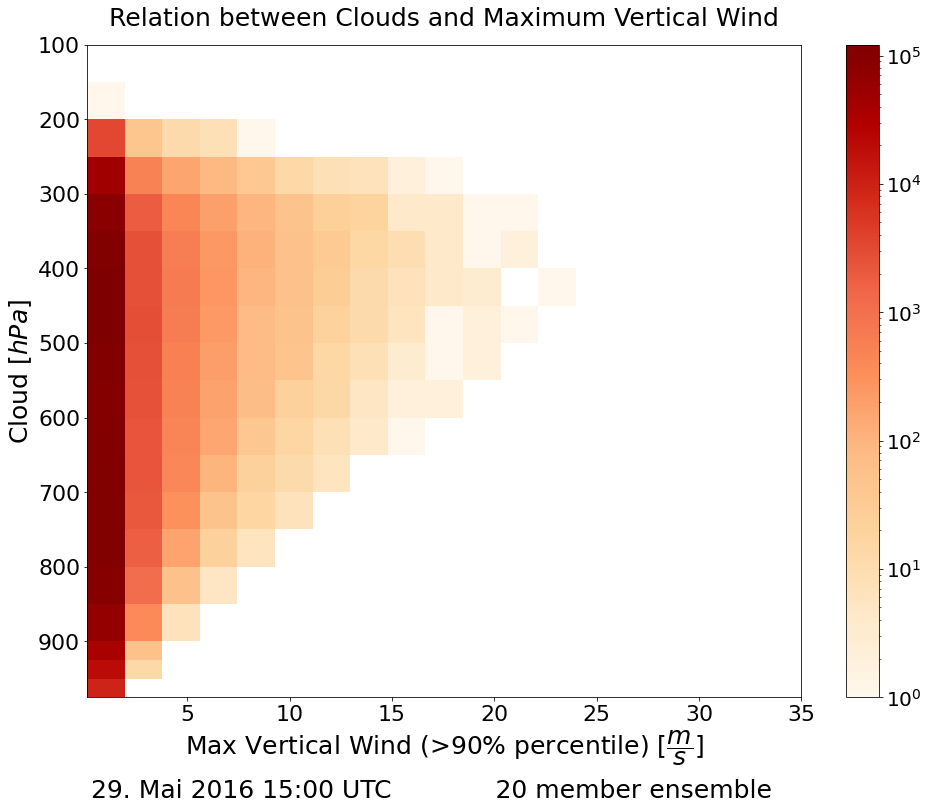

In [32]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

#w_max.flatten(),cloud_height_total.flatten()
# plt.gca().set_facecolor(plt.get_cmap('OrRd')(0))

plt.gca().set_facecolor('w')
plt.hist2d(w_max.flatten(),h_cloud.flatten(),bins=[np.linspace(np.nanpercentile(w,90),35,20),np.flip(dataset_CL.coords['lev'].values)],norm=matplotlib.colors.LogNorm(),cmap='OrRd')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

ax.invert_yaxis()
ax.set_ylabel('Cloud [$hPa$]',size = 25)
ax.set_xlabel('Max Vertical Wind (>90% percentile) [$\dfrac{m}{s}$]',size = 25)
ax.set_title('Relation between Clouds and Maximum Vertical Wind', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)
ax.text(0.3,1110,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)

(array([-0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

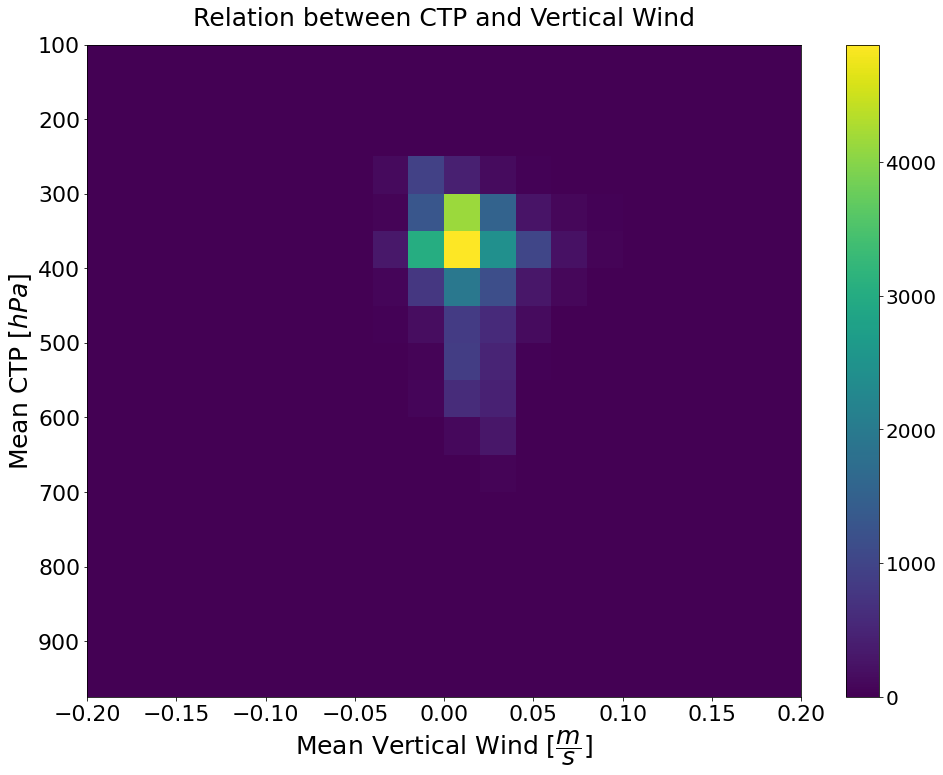

In [34]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist2d(w_mean_ens_lev.flatten(),ctp_mean.flatten(),bins=[np.linspace(-0.2,0.2,21),np.flip(dataset_CL.coords['lev'].values)])
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

ax.invert_yaxis()
ax.set_ylabel('Mean CTP [$hPa$]',size = 25)
ax.set_xlabel('Mean Vertical Wind [$\dfrac{m}{s}$]',size = 25)
ax.set_title('Relation between CTP and Vertical Wind', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)


# plt.hist2d(dummy.flatten(),ctl_mean.flatten())
# plt.colorbar()

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

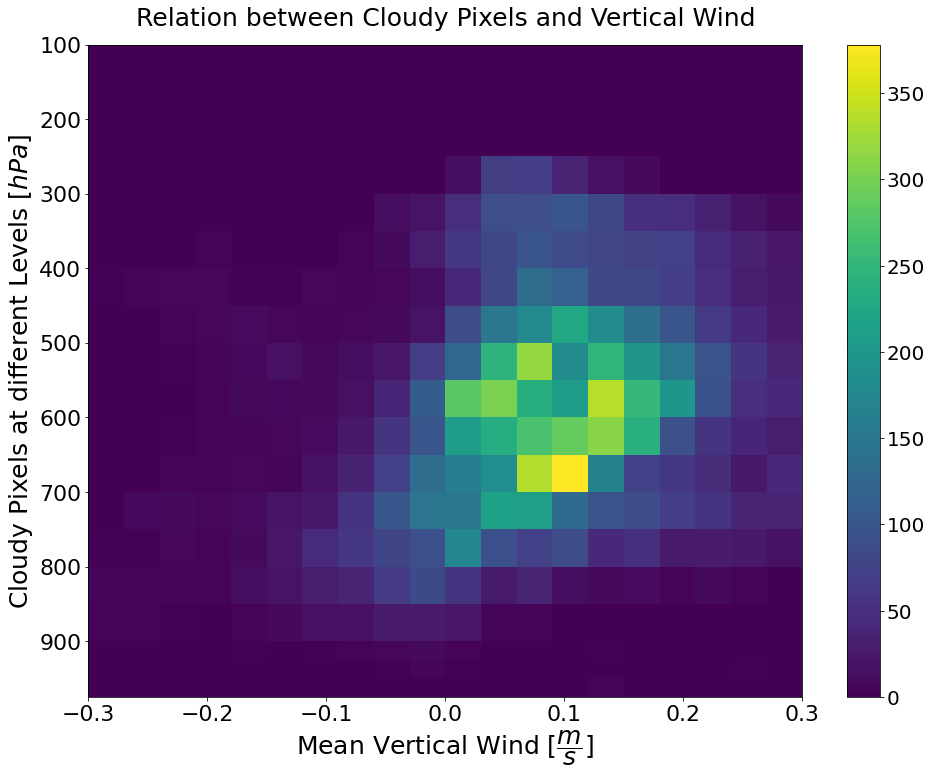

In [35]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist2d(w_mean_ens.flatten(),np.mean(h_cloud,axis=0).flatten(),bins=[np.linspace(-0.3,0.3,21),np.flip(dataset_CL.coords['lev'].values)])
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

ax.invert_yaxis()
ax.set_ylabel('Cloudy Pixels at different Levels [$hPa$]',size = 25)
ax.set_xlabel('Mean Vertical Wind [$\dfrac{m}{s}$]',size = 25)
ax.set_title('Relation between Cloudy Pixels and Vertical Wind', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

(array([-0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
         0.1  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

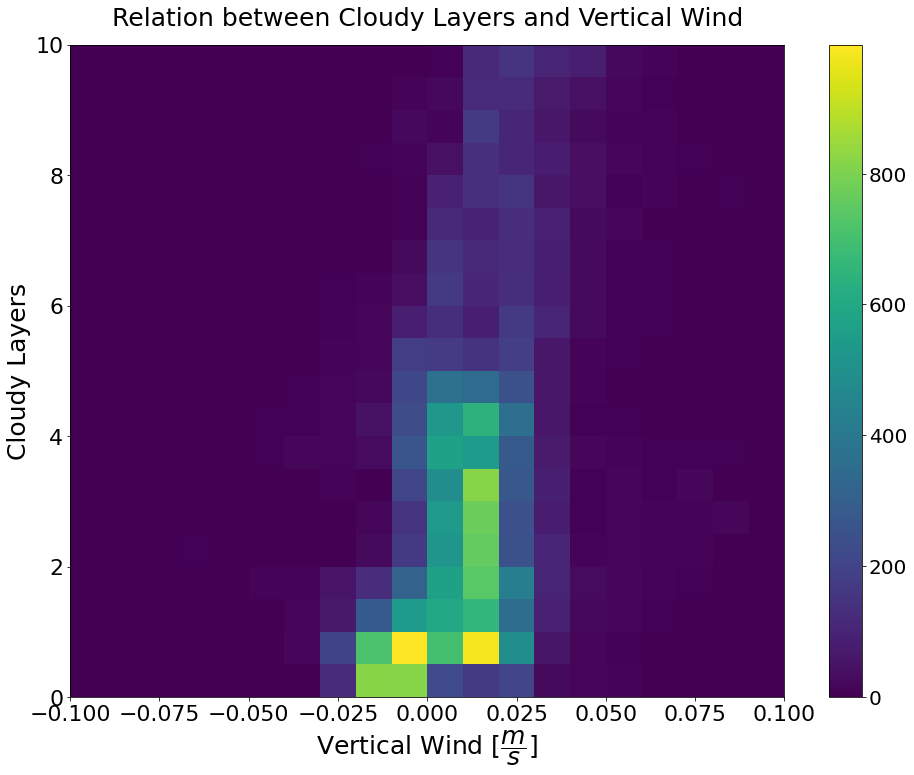

In [37]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist2d(w_mean_ens_lev.flatten(),np.mean(ex_cloud,axis = 0).flatten(),bins=[np.linspace(-0.1,0.1,21),np.linspace(0,10,21)])
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# ax.invert_yaxis()
ax.set_ylabel('Cloudy Layers',size = 25)
ax.set_xlabel('Vertical Wind [$\dfrac{m}{s}$]',size = 25)
ax.set_title('Relation between Cloudy Layers and Vertical Wind', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

(array([ 0,  2,  4,  6,  8, 10]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

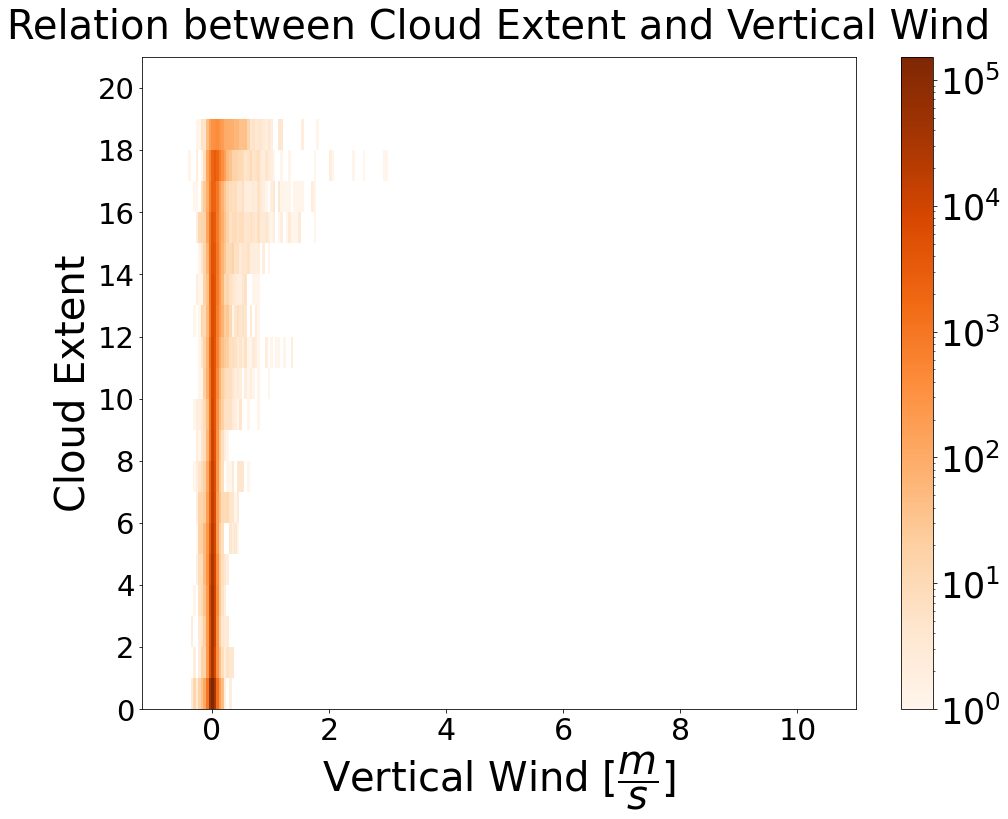

In [38]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist2d(w_mean_lev.flatten(),ex_cloud.flatten(),bins=[np.linspace(-1.2,11,int(np.sqrt(lon2d.size))),np.linspace(0,21,22)],norm=matplotlib.colors.LogNorm(),cmap='Oranges')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=35)

# ax.invert_yaxis()
ax.set_ylabel('Cloud Extent',size = 40)
ax.set_xlabel('Vertical Wind [$\dfrac{m}{s}$]',size = 40)
ax.set_title('Relation between Cloud Extent and Vertical Wind', size =40,y=1.02)
ax.set_yticks(ticks=np.arange(0,21,2))
ax.set_xticks(ticks=np.arange(0,11,2))
plt.yticks(fontsize=29)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_2d_hist_l_cloud_w_'+ens+'mem_2016'+date+'1500.png')

### Stability

(array([10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

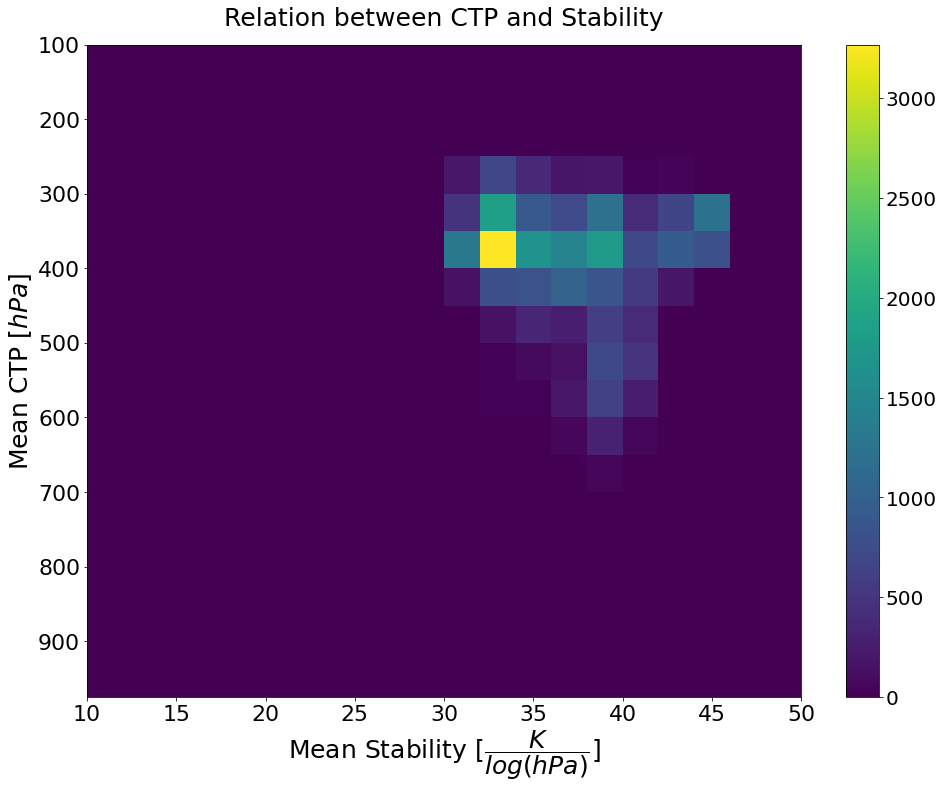

In [42]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)
#[3:11]
plt.hist2d(np.mean(stab,axis = (0,1)).flatten(),ctp_mean.flatten(),bins=[np.linspace(10,50,21),np.flip(dataset_CL.coords['lev'].values)])
# plt.hist2d(np.mean(stab[0:15],axis = 0).flatten(),ctp_mean.flatten(),bins=[np.linspace(10,50,21),np.flip(dataset_CL.coords['lev'].values)])
# plt.hist2d(np.mean(stab[3:11],axis = 0).flatten(),ctp_mean.flatten(),bins=[np.linspace(10,50,21),np.flip(dataset_CL.coords['lev'].values)])
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

ax.invert_yaxis()
ax.set_ylabel('Mean CTP [$hPa$]',size = 25)
ax.set_xlabel('Mean Stability [$\dfrac{K}{log(hPa)}$]',size = 25)
ax.set_title('Relation between CTP and Stability', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

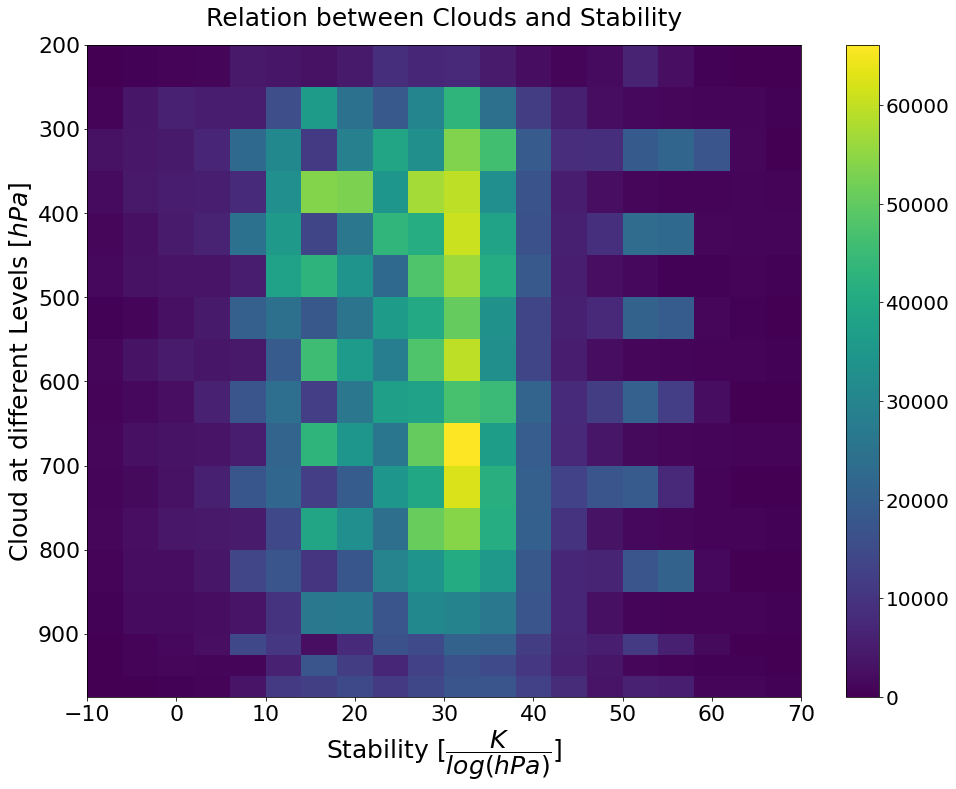

In [43]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist2d(stab.flatten(),h_cloud[1:19].flatten(),bins=[np.linspace(-10,70,21),np.flip(dataset_CL.coords['lev'].values[0:18])])
# plt.hist2d(stab[0:15].flatten(),cloud_height[1:16].flatten(),bins=[np.linspace(-10,70,21),np.flip(dataset_CL.coords['lev'].values[0:17])]) #950-300 hPa 
# plt.hist2d(stab[3:11].flatten(),cloud_height[4:12].flatten(),bins=[np.linspace(-10,70,21),np.flip(dataset_CL.coords['lev'].values[2:13])]) #850-500 hPa
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

ax.invert_yaxis()
ax.set_ylabel('Cloud at different Levels [$hPa$]',size = 25)
ax.set_xlabel('Stability [$\dfrac{K}{log(hPa)}$]',size = 25)
ax.set_title('Relation between Clouds and Stability', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

Text(29.1, -3.5, '29. Mai 2016 15:00 UTC             20 member ensemble')

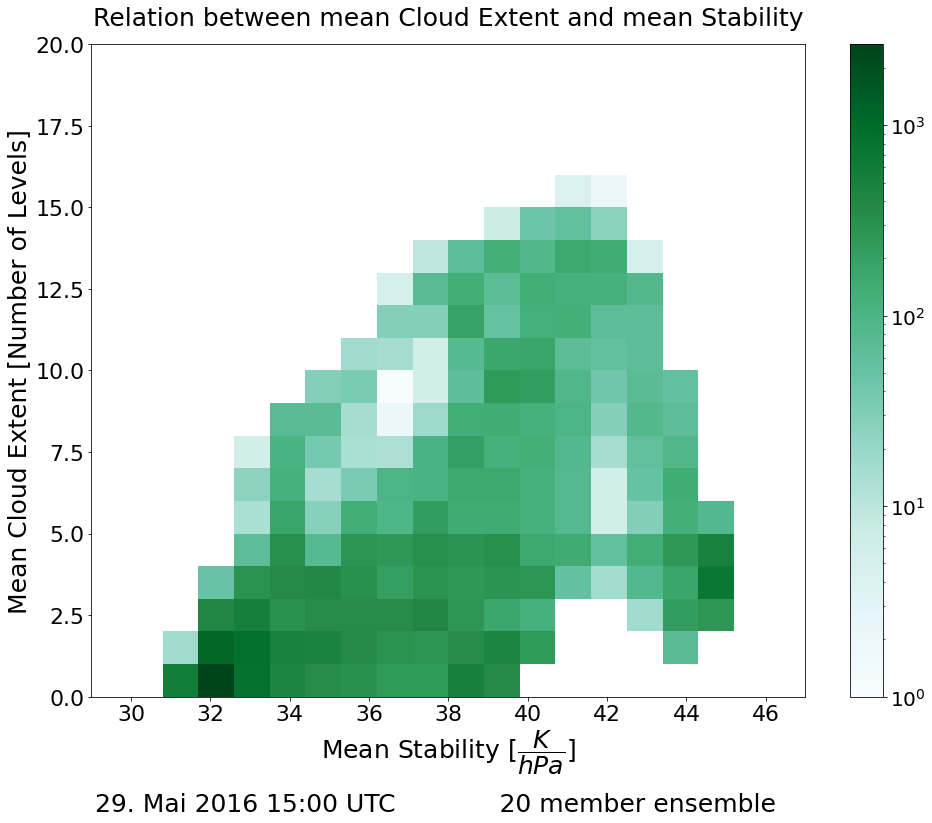

In [46]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.gca().set_facecolor('w')
plt.hist2d(np.mean(stab,axis = (0,1)).flatten(),np.mean(ex_cloud,axis=0).flatten(),bins=[np.linspace(29,47,21),np.linspace(0,20,21)],norm=matplotlib.colors.LogNorm(),cmap='BuGn')
# plt.hist2d(np.mean(stab[0:15],axis = 0).flatten(),l_cloud.flatten(),bins=[np.linspace(29,47,21),np.linspace(0,20,21)]) #950-300 hPa 
# plt.hist2d(np.mean(stab[3:11],axis = 0).flatten(),l_cloud.flatten(),bins=[np.linspace(29,47,21),np.linspace(0,20,21)]) #850-500 hPa
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# ax.invert_yaxis()
ax.set_ylabel('Mean Cloud Extent [Number of Levels]',size = 25)
ax.set_xlabel('Mean Stability $ [\dfrac{K}{hPa}] $',size = 25)
ax.set_title('Relation between mean Cloud Extent and mean Stability', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

plt.gca().set_facecolor('w')
ax.text(29.1,-3.5,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

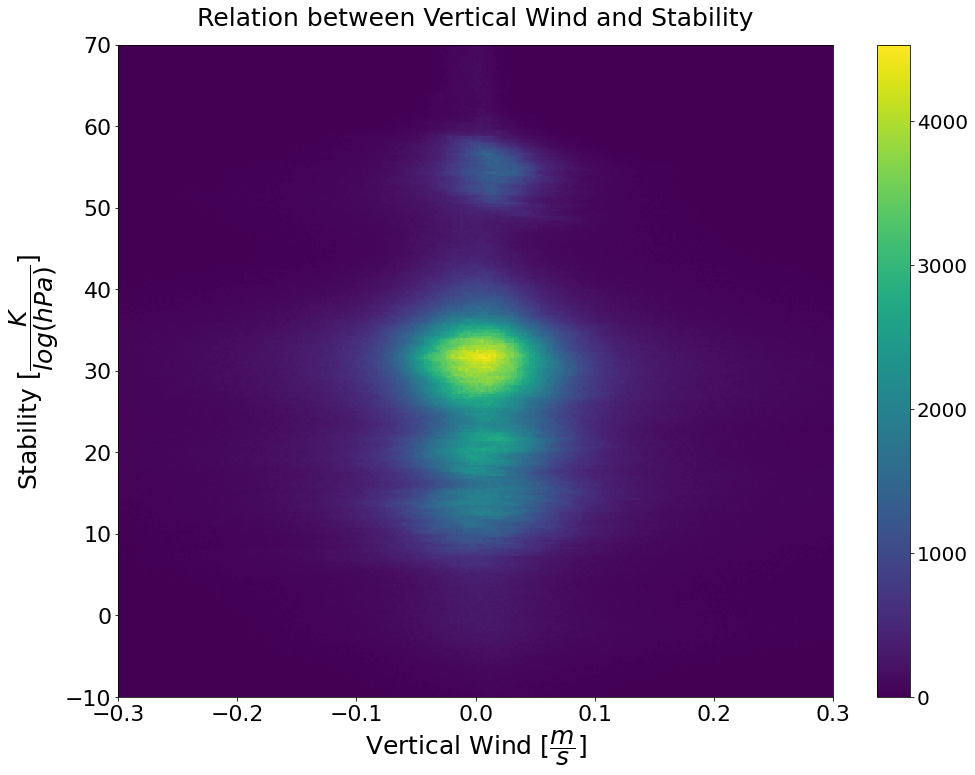

In [48]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)
#[3:11]
plt.hist2d(w[::,1:19].flatten(),stab.flatten(),bins=[np.linspace(-0.3,0.3,int(np.sqrt(lon2d.size))),np.linspace(-10,70,int(np.sqrt(lon2d.size)))])#,norm=matplotlib.colors.LogNorm())

cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# ax.invert_yaxis()
ax.set_ylabel('Stability [$\dfrac{K}{log(hPa)}$]',size = 25)
ax.set_xlabel('Vertical Wind [$\dfrac{m}{s}$]',size = 25)
ax.set_title('Relation between Vertical Wind and Stability', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

### Precipitation

(array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

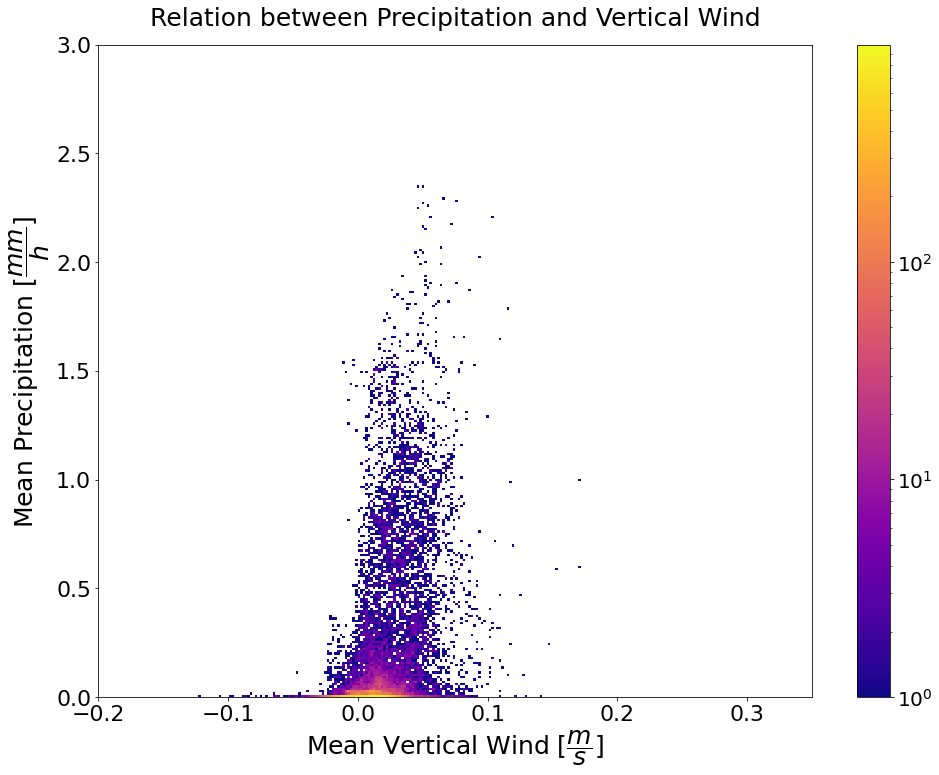

In [50]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist2d(w_mean_ens_lev.flatten(),np.mean(prec*3600,axis=0).flatten(),bins=[np.linspace(-0.2,0.35,int(np.sqrt(lon2d.size))),np.linspace(0,3,int(np.sqrt(lon2d.size)))],norm=matplotlib.colors.LogNorm(),cmap='plasma')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# ax.invert_yaxis()
ax.set_ylabel('Mean Precipitation [$\dfrac{mm}{h}$]',size = 25)
ax.set_xlabel('Mean Vertical Wind [$\dfrac{m}{s}$]',size = 25)
ax.set_title('Relation between Precipitation and Vertical Wind', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

(array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

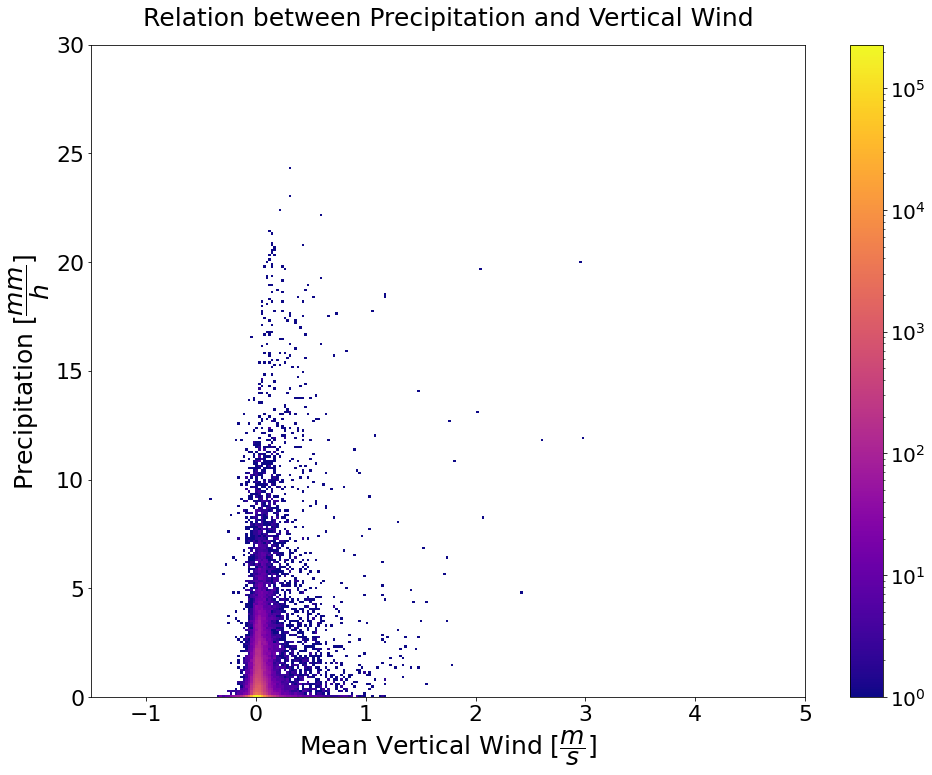

In [55]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist2d(w_mean_lev.flatten(),(prec*3600).flatten(),bins=[np.linspace(-1.5,5,int(np.sqrt(lon2d.size))),np.linspace(0,30,int(np.sqrt(lon2d.size)))],norm=matplotlib.colors.LogNorm(),cmap='plasma')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# ax.invert_yaxis()
ax.set_ylabel('Precipitation [$\dfrac{mm}{h}$]',size = 25)
ax.set_xlabel('Mean Vertical Wind [$\dfrac{m}{s}$]',size = 25)
ax.set_title('Relation between Precipitation and Vertical Wind', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

## Plotting 1-D Histograms

### Vertical Wind

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

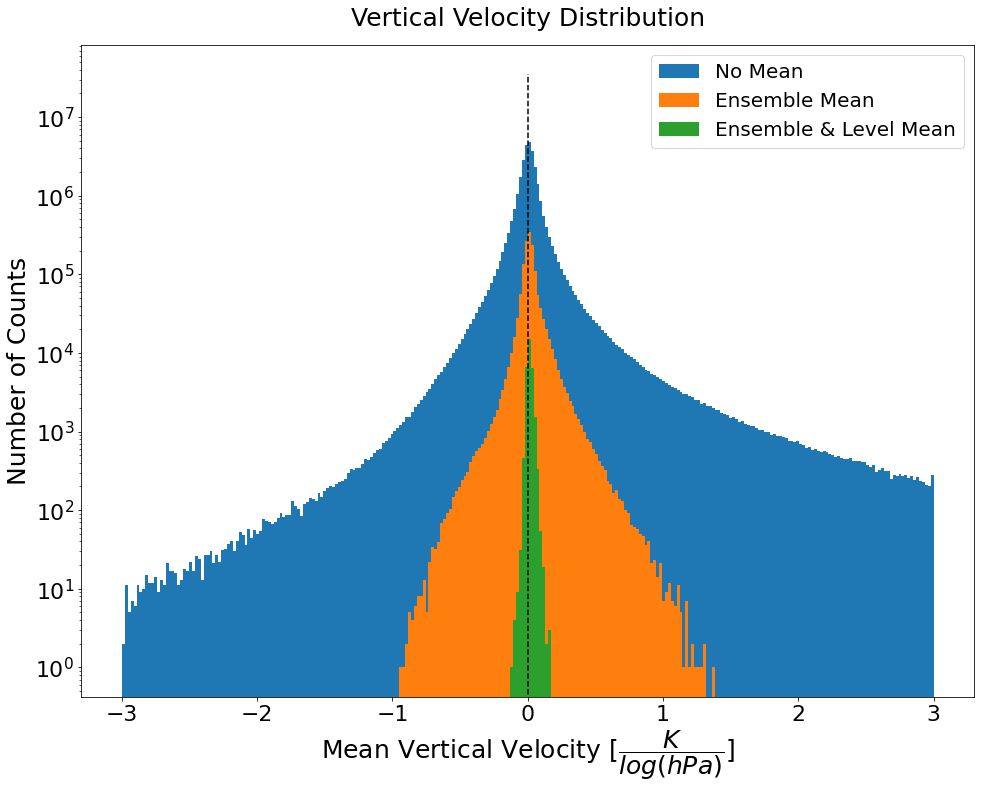

In [56]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(w.flatten().flatten(),bins = np.linspace(-3,3,int(np.sqrt(lon2d.size))),rwidth = 1,label='No Mean')
plt.hist(w_mean_ens.flatten().flatten(),bins = np.linspace(-3,3,int(np.sqrt(lon2d.size))),rwidth = 1,label='Ensemble Mean')
plt.hist(w_mean_ens_lev.flatten().flatten(),bins = np.linspace(-3,3,int(np.sqrt(lon2d.size))),rwidth = 1,label='Ensemble & Level Mean')

plt.legend(fontsize=20)

ax.vlines(0,ymin=0,ymax=35000000,linestyle='--',color='k')
ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('Mean Vertical Velocity [$\dfrac{K}{log(hPa)}$]',size = 25)
ax.set_title('Vertical Velocity Distribution', size =25,y=1.02)
ax.set_yscale('log')
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

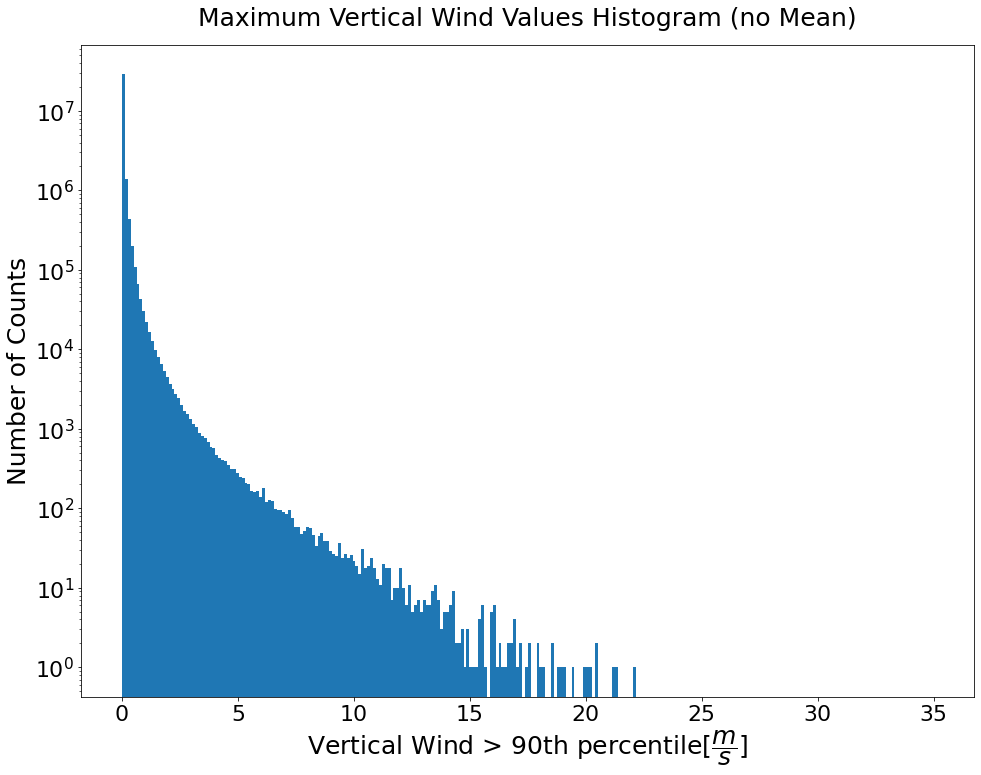

In [57]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(w_max.flatten(),bins = np.linspace(0,35,int(np.sqrt(lon2d.size))),rwidth = 1)

# ax.invert_xaxis()
ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('Vertical Wind > 90th percentile[$\dfrac{m}{s}$]',size = 25)
ax.set_title('Maximum Vertical Wind Values Histogram (no Mean)', size =25,y=1.02)
ax.set_yscale('log')
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

### Stability

(array([27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

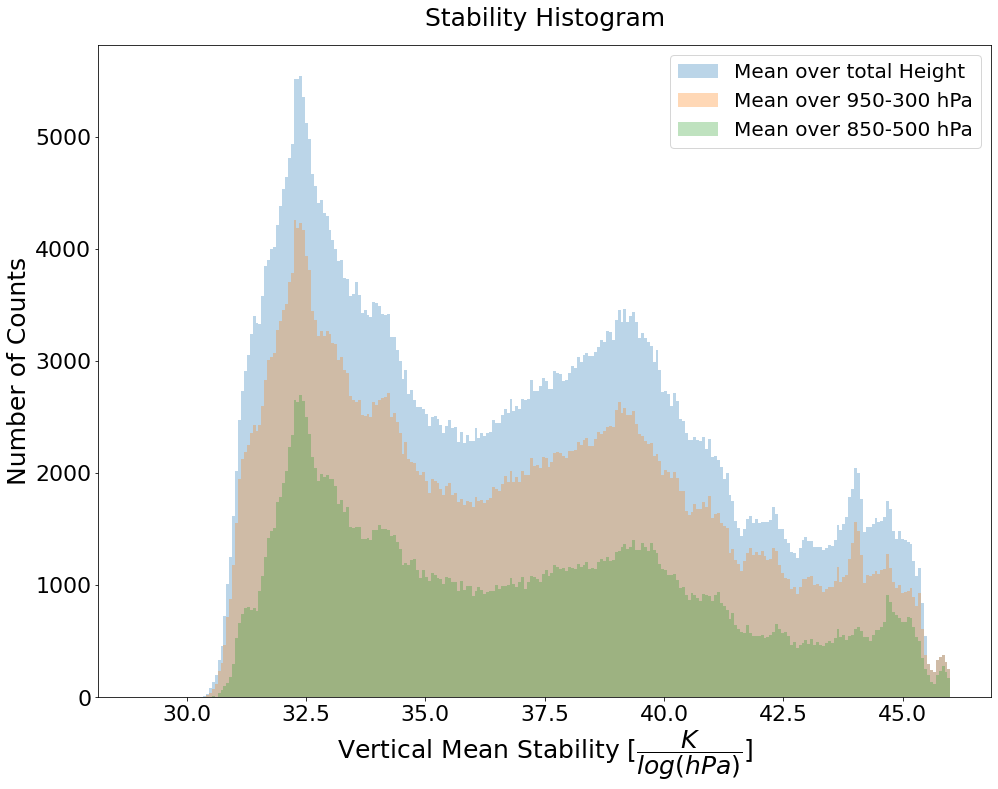

In [62]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(np.mean(stab,axis=1).flatten(),bins = np.linspace(29,46,int(np.sqrt(lon2d.size))),rwidth = 1,alpha=0.3,label='Mean over total Height')
plt.hist(np.mean(stab[0:15],axis=1).flatten(),bins = np.linspace(29,46,int(np.sqrt(lon2d.size))),rwidth = 1,alpha=0.3,label='Mean over 950-300 hPa') #950-300 hPa 
plt.hist(np.mean(stab[3:11],axis=1).flatten(),bins = np.linspace(29,46,int(np.sqrt(lon2d.size))),rwidth = 1,alpha=0.3,label='Mean over 850-500 hPa') #850-500 hPa
plt.legend(fontsize=20)

# ax.invert_xaxis()
ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('Vertical Mean Stability [$\dfrac{K}{log(hPa)}$]',size = 25)
ax.set_title('Stability Histogram', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

(array([-50.,   0.,  50., 100., 150., 200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

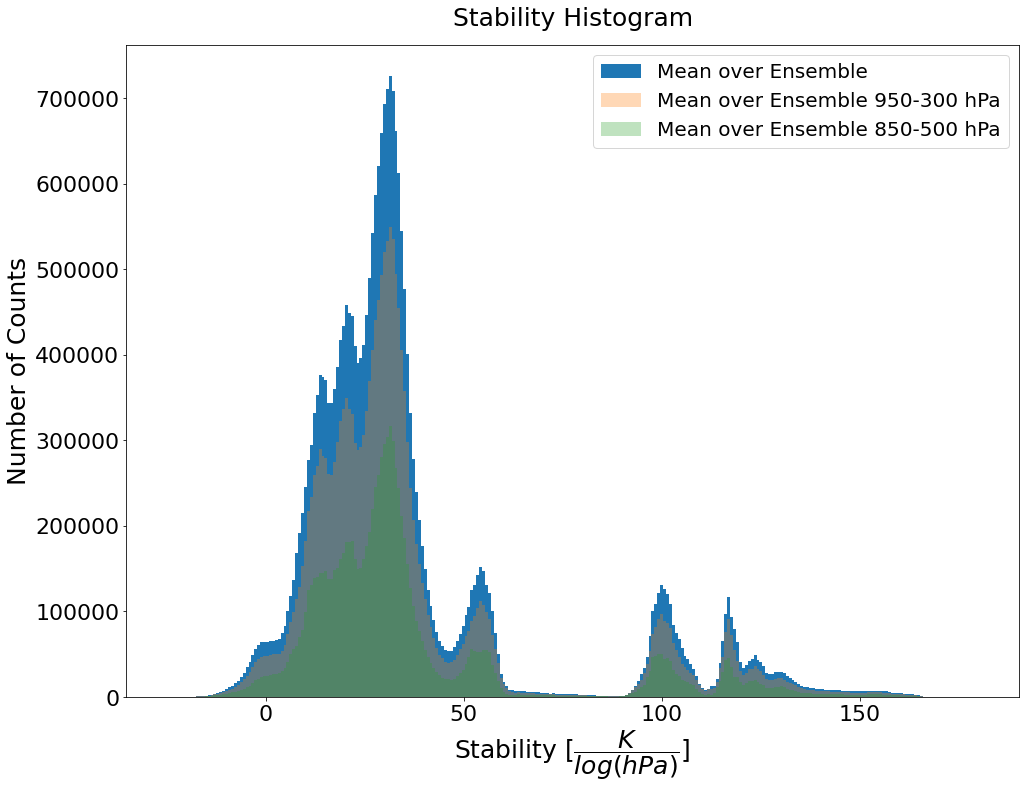

In [68]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(stab.flatten(),bins = np.linspace(-25,180,int(np.sqrt(lon2d.size))),rwidth = 1,label='No Mean')
plt.hist(stab[0:15].flatten(),bins = np.linspace(-25,180,int(np.sqrt(lon2d.size))),rwidth = 1,alpha=0.3,label='No Mean 950-300 hPa') #950-300 hPa 
plt.hist(stab[3:11].flatten(),bins = np.linspace(-25,180,int(np.sqrt(lon2d.size))),rwidth = 1,alpha=0.3,label='No Mean 850-500 hPa') #850-500 hPa
plt.legend(fontsize=20)

# ax.invert_xaxis()
ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('Stability [$\dfrac{K}{log(hPa)}$]',size = 25)
ax.set_title('Stability Histogram', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

### Precipitation

(array([-20.,   0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

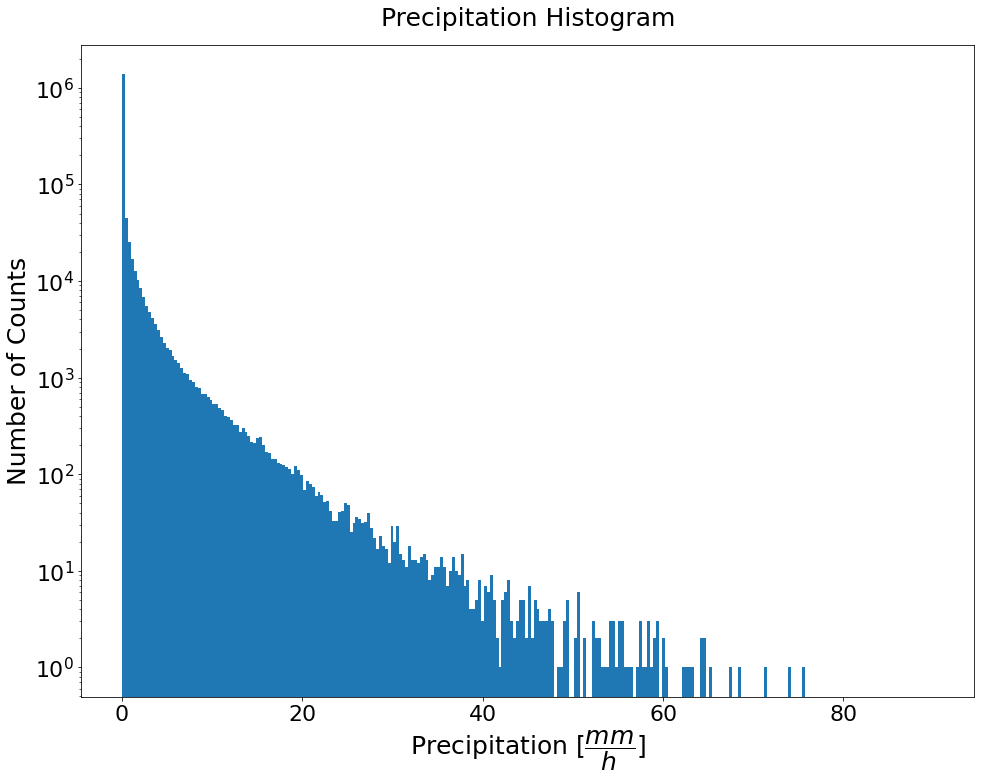

In [70]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist((prec*3600).flatten(),bins = np.linspace(0,90,int(np.sqrt(lon2d.size))),rwidth = 1)

ax.set_yscale('log')
ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('Precipitation [$\dfrac{mm}{h}$]',size = 25)
ax.set_title('Precipitation Histogram', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

([<matplotlib.axis.XTick at 0x7f25eeaf2f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

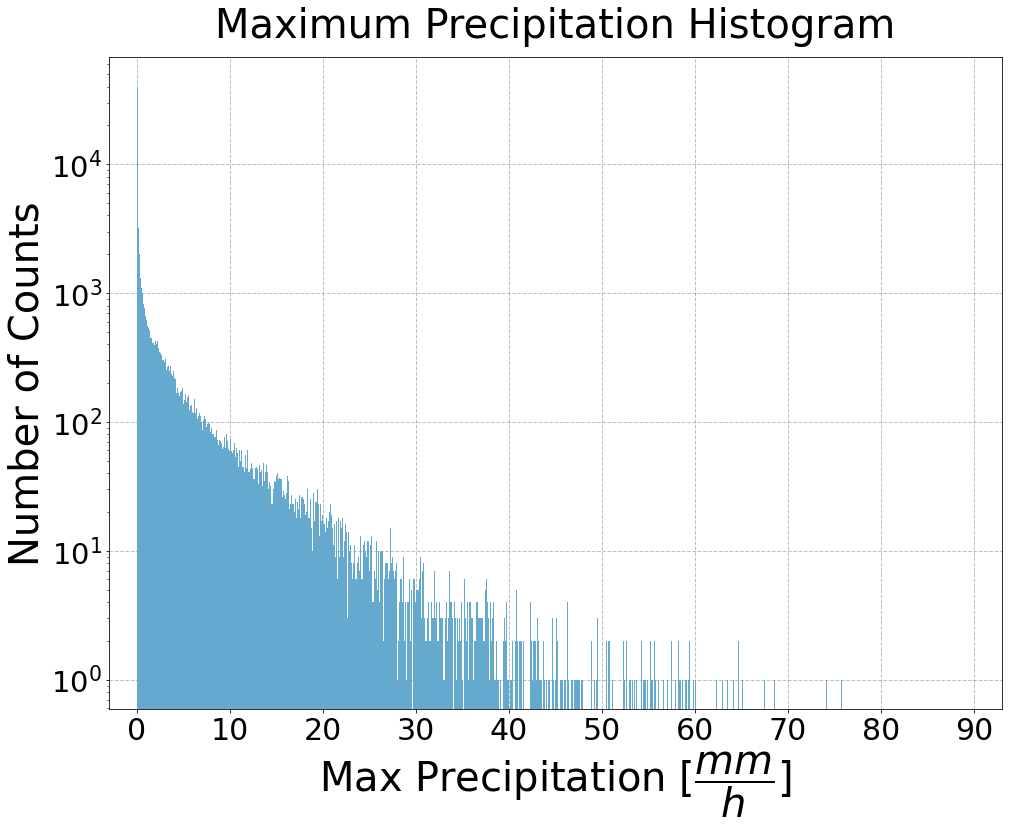

In [72]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist((np.max(prec,axis=0)*3600).flatten(),bins = np.linspace(0,90,1000),rwidth = 1,color=plt.cm.PuBuGn(128),zorder=3)

ax.set_yscale('log')
ax.set_ylabel('Number of Counts',size = 40)
ax.set_xlabel('Max Precipitation [$\dfrac{mm}{h}$]',size = 40)
ax.set_title('Maximum Precipitation Histogram', size =40,y=1.02)
ax.grid(zorder=0, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.text(-3,0.13,day+'. '+m+' 2016 '+t+' UTC                                    '+ens+' member ensemble', size =25)
plt.xlim(-3,93)
plt.yticks(fontsize=29)
plt.xticks(np.linspace(0,90,10),fontsize=30)

# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_hist_prec_'+ens+'mem_2016'+date+'1500.png')

# ,color=plt.cm.Blues(128),zorder=3)
# ax.text(850,-2700,day+'. '+m+' 2016 '+t+' UTC                                    '+ens+' member ensemble', size =25)
# ax.grid(zorder=0, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# plt.xlim(850,150)
# plt.ylim(0,20000)

### Cloud Variables

(array([ 200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

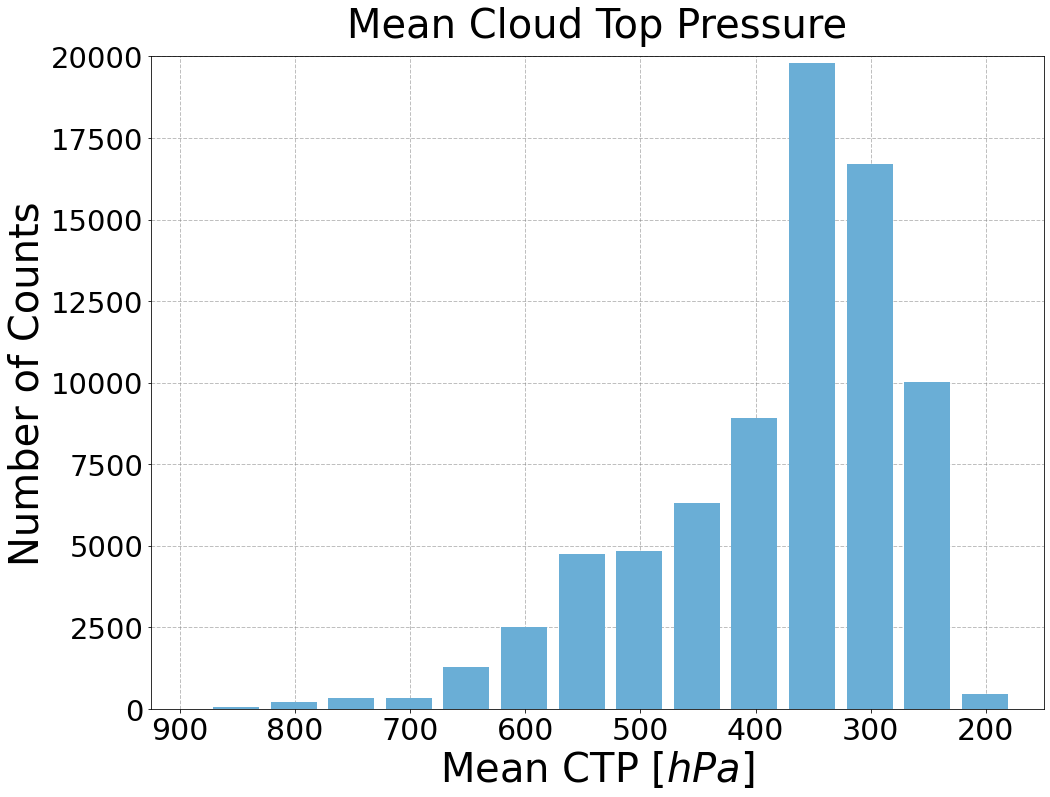

In [73]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)
#plt.get_cmap('Blues')(300)
plt.hist(ctp_mean.flatten(),bins = np.flip(dataset_CL.coords['lev'].values[3::]+1),range=[100,975],rwidth = 0.8,align='right',color=plt.cm.Blues(128),zorder=3)

# ax.text(850,-2700,day+'. '+m+' 2016 '+t+' UTC                                    '+ens+' member ensemble', size =25)
ax.set_xticks(ticks=np.linspace(200,1000,9))
ax.grid(zorder=0, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.invert_xaxis()
ax.set_ylabel('Number of Counts',size = 40)
ax.set_xlabel('Mean CTP [$hPa$]',size = 40)
ax.set_title('Mean Cloud Top Pressure', size =40,y=1.02)
plt.xlim(925,150)
plt.ylim(0,20000)
plt.yticks(fontsize=29)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_hist_ctp_mean_'+ens+'mem_2016'+date+'1500.png')

([<matplotlib.axis.XTick at 0x7f25ee169190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

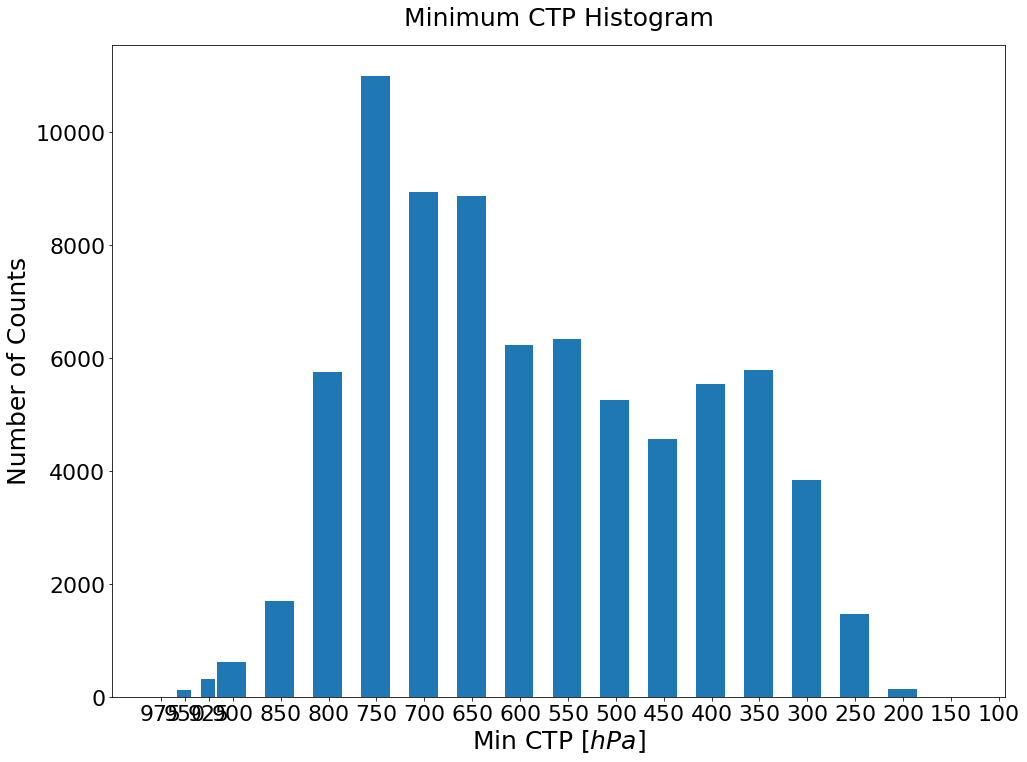

In [74]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(ctp_min.flatten(),bins = np.flip(dataset_CL.coords['lev'].values+1),range=[100,975],rwidth = 0.6,align='right')

ax.invert_xaxis()
ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('Min CTP [$hPa$]',size = 25)
ax.set_title('Minimum CTP Histogram', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(ticks = dataset_CL.coords['lev'].values,fontsize=22)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

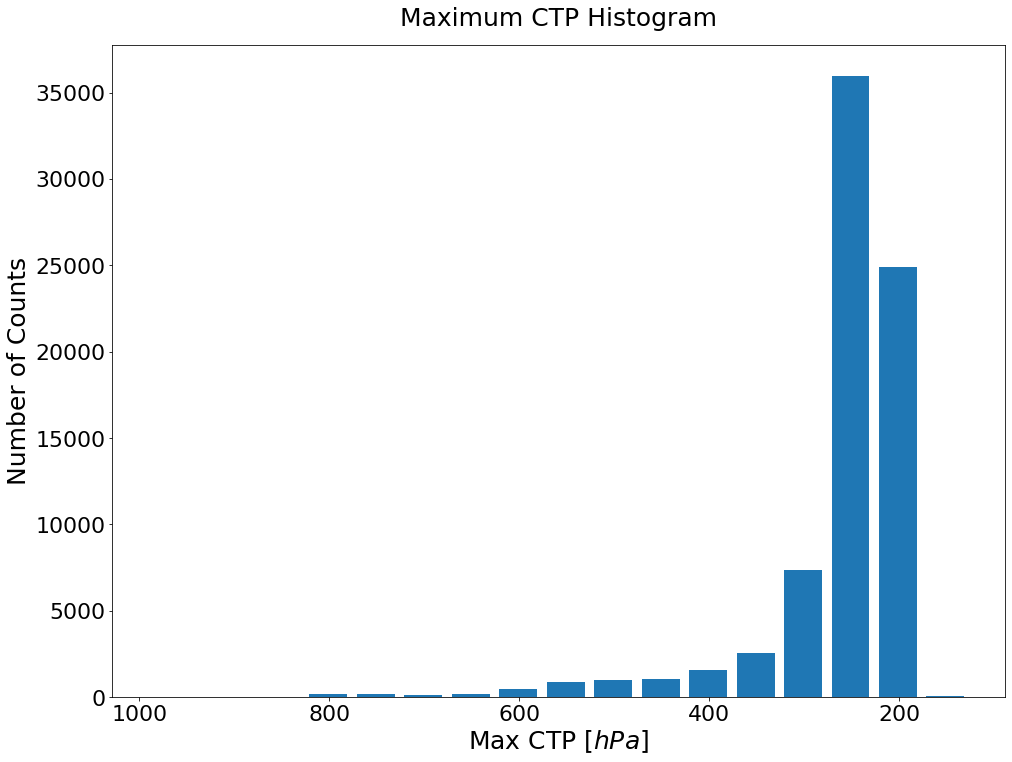

In [75]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(ctp_max.flatten(),bins = np.flip(dataset_CL.coords['lev'].values+1),range=[100,975],rwidth = 0.8,align='right')

ax.invert_xaxis()
ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('Max CTP [$hPa$]',size = 25)
ax.set_title('Maximum CTP Histogram', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

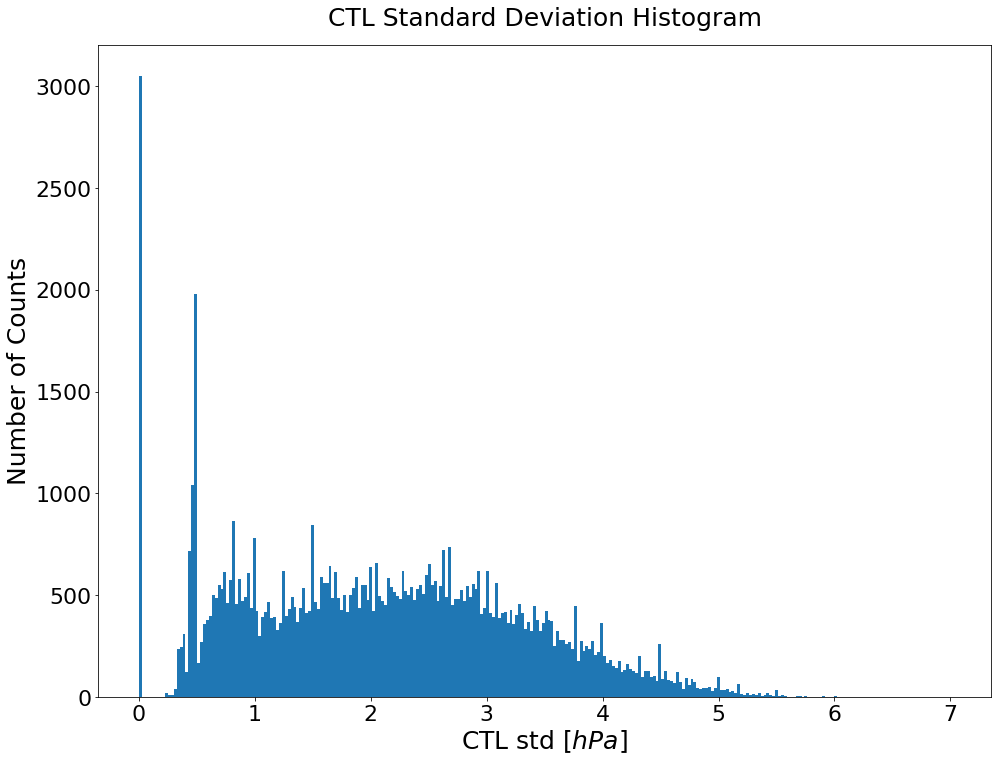

In [77]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)
#int(0.2*np.sqrt(lon2d_slice.size)))
plt.hist(ctl_std.flatten(),bins= np.linspace(0,7,int(np.sqrt(lon2d.size))),rwidth = 1)

# ax.invert_xaxis()
ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('CTL std [$hPa$]',size = 25)
ax.set_title('CTL Standard Deviation Histogram', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)


([<matplotlib.axis.XTick at 0x7f25ed48b670>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

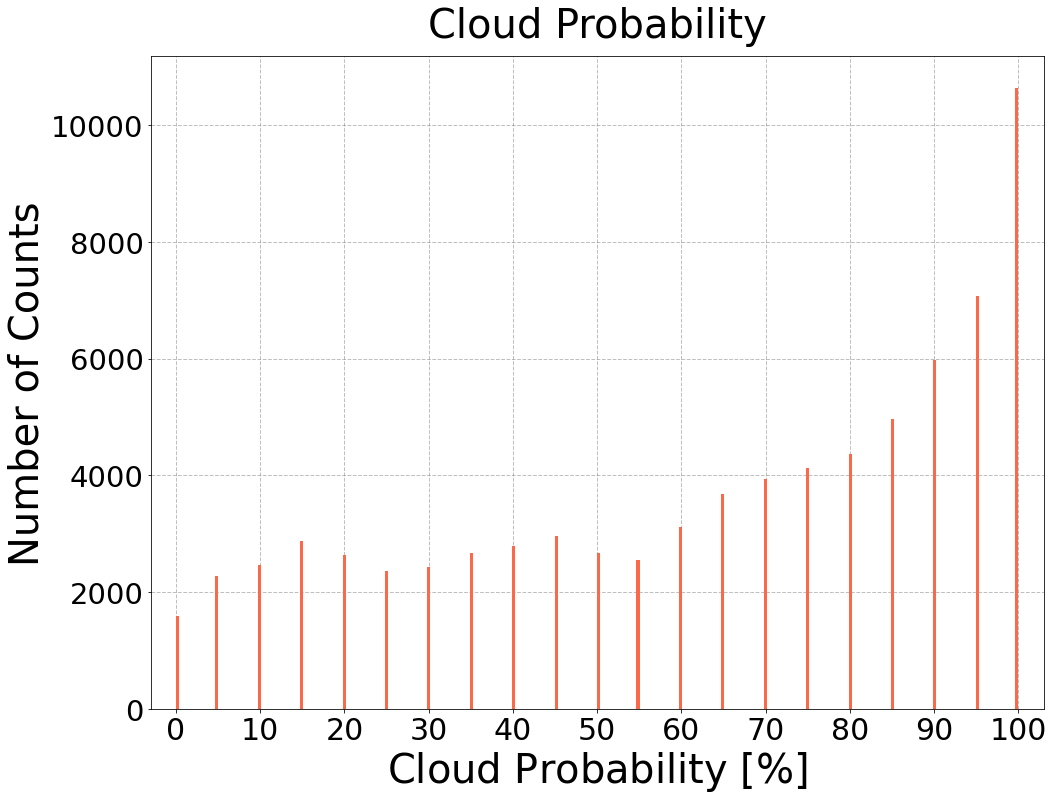

In [81]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(p_cloud.flatten()*100,bins = np.linspace(0,100,int(np.sqrt(lon2d.size))),rwidth = 1,color=plt.cm.Reds(128),zorder=3)

ax.set_ylabel('Number of Counts',size = 40)
ax.set_xlabel('Cloud Probability [$\%$]',size = 40)
ax.set_title('Cloud Probability', size =40,y=1.02)
# ax.text(-3,-130,day+'. '+m+' 2016 '+t+' UTC                                    '+ens+' member ensemble', size =25)
ax.grid(zorder=0, linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.xlim(-3,103)
plt.yticks(fontsize=29)
plt.xticks(np.linspace(0,100,11),fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_hist_cloud_p_'+ens+'mem_2016'+date+'1500.png')

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

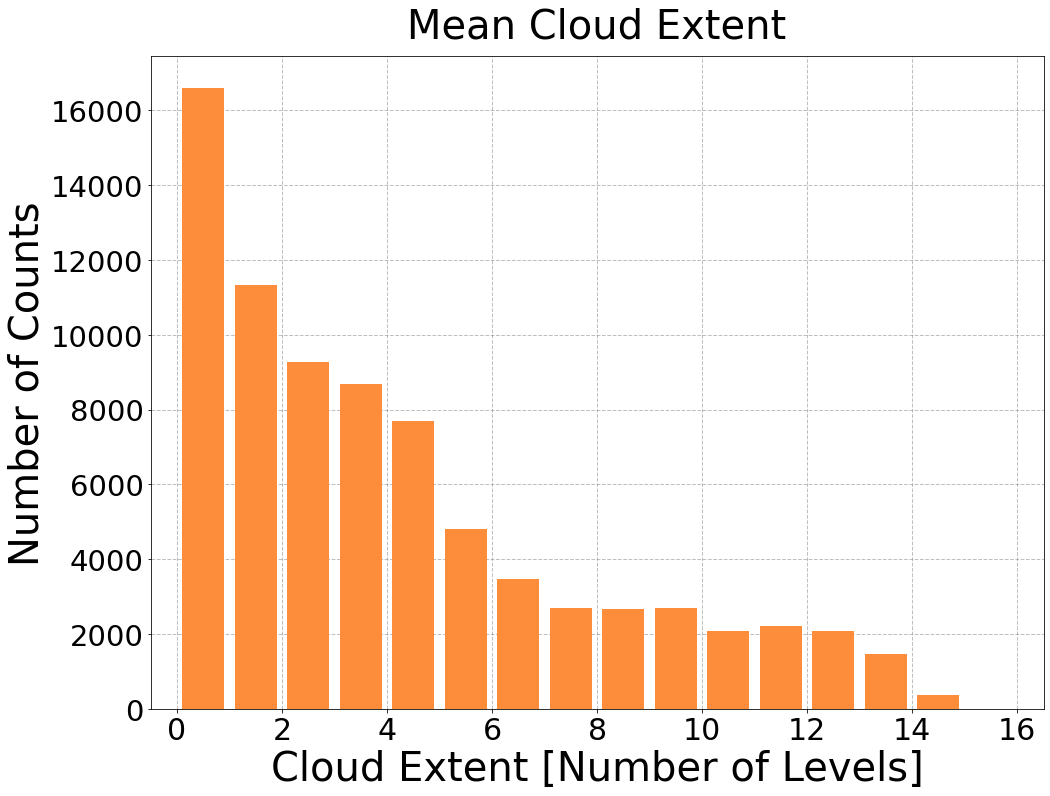

In [82]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(np.mean(ex_cloud,axis=0).flatten(),bins = np.linspace(0,20,21),rwidth = 0.8,align='mid',color=plt.cm.Oranges(128),zorder=3)

ax.set_ylabel('Number of Counts',size = 40)
ax.set_xlabel('Cloud Extent [Number of Levels]',size = 40)
ax.set_title('Mean Cloud Extent', size =40,y=1.02)
ax.grid(zorder=0, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.text(-0.5,-2400,day+'. '+m+' 2016 '+t+' UTC                                    '+ens+' member ensemble', size =25)
plt.xlim(-0.5,16.5)
plt.yticks(fontsize=29)
plt.xticks(fontsize=30)

# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_hist_l_cloud_'+ens+'mem_2016'+date+'1500.png')

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

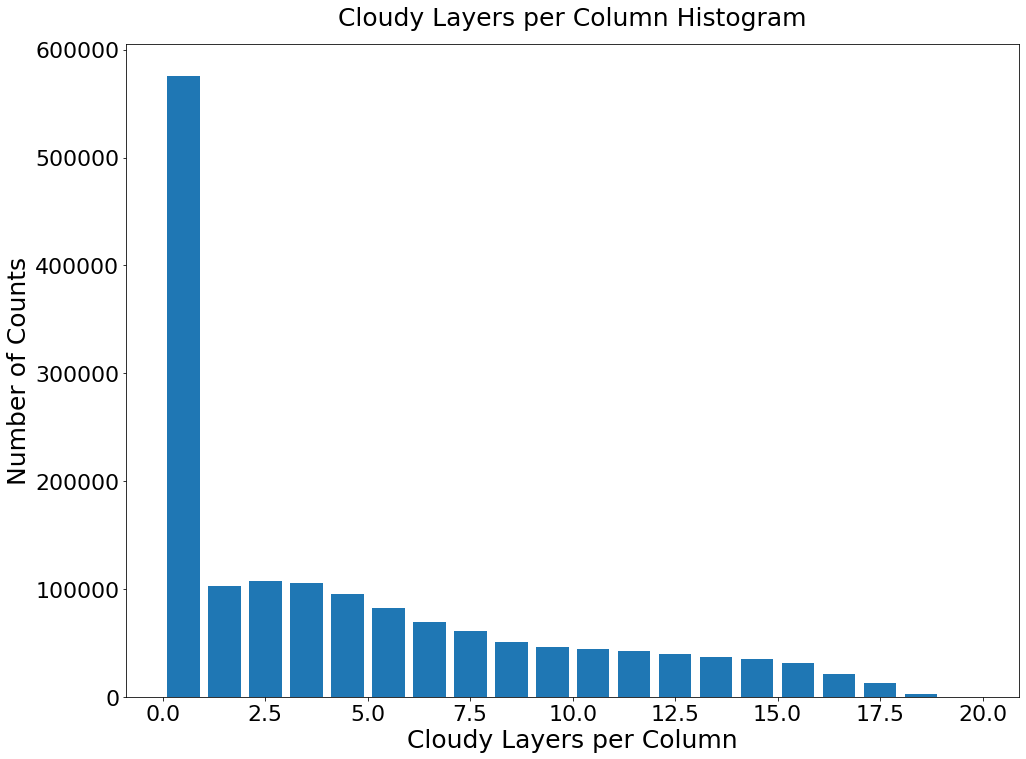

In [83]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

plt.hist(ex_cloud.flatten(),bins = np.linspace(0,20,21),rwidth = 0.8,align = 'mid')

ax.set_ylabel('Number of Counts',size = 25)
ax.set_xlabel('Cloudy Layers per Column',size = 25)
ax.set_title('Cloudy Layers per Column Histogram', size =25,y=1.02)
plt.yticks(fontsize=22)
plt.xticks(fontsize=22)